In [1]:
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go



In [123]:
# Import API key
from api_keys import geoapify_key
print(geoapify_key)

9620974308c6477c8f3e31f84708640f


In [2]:
# Load the CSV file for Property infomation into a Pandas DataFrame
csv_file = Path("Resources/Property_Sales_Melbourne_City.csv")
property_database = pd.read_csv(csv_file)

# Load the CSV file for interest rate infomation into a Pandas DataFrame
csv_file = Path("Resources/Interest _Rate_Monthly_Avg.csv")
interest_rate_database = pd.read_csv(csv_file)

# Display sample data
property_database.head()

,Unnamed: 0,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,1,Abbotsford,85 Turner St,2,h,1480000,S,Biggin,3/12/2016,2.5,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,2,Abbotsford,25 Bloomburg St,2,h,1035000,S,Biggin,4/02/2016,2.5,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,4,Abbotsford,5 Charles St,3,h,1465000,SP,Biggin,4/03/2017,2.5,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,5,Abbotsford,40 Federation La,3,h,850000,PI,Biggin,4/03/2017,2.5,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,6,Abbotsford,55a Park St,4,h,1600000,VB,Nelson,4/06/2016,2.5,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [92]:
#Create a function that determines seasons function based on months function

# Define a function that maps each month to a season
def get_season(month):
    if month in ['Dec', 'Jan', 'Feb']:
        return 'Winter'
    elif month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    else:
        return 'Autumn'

In [93]:
#Get the date column converted, so we can get month and year separated
# Convert the Date column to a Pandas datetime format
property_database['Date'] = pd.to_datetime(property_database['Date'], format='%d/%m/%Y')

# Create a new column for Month_Year
property_database['Month_Year'] = property_database['Date'].dt.strftime('%b-%Y')

# Group the data by Month_Year and calculate the mean price and count of sales for each group
price_by_month_year = property_database.groupby('Month_Year').agg({'Price': 'mean', 'Date': 'count'}).reset_index()

# Rename the 'Date' column to 'Sales'
price_by_month_year = price_by_month_year.rename(columns={'Date': 'Count of Sales'})

# Add a new column for season based on the Month_Year column
price_by_month_year['Season'] = price_by_month_year['Month_Year'].apply(lambda x: get_season(x[:3]))

# Convert the Month_Year column to a Pandas datetime format
price_by_month_year['Month_Year'] = pd.to_datetime(price_by_month_year['Month_Year'], format='%b-%Y')

# Sort the DataFrame by Month_Year
price_by_month_year = price_by_month_year.sort_values('Month_Year').reset_index()

# Convert the Month_Year column back to a string
price_by_month_year['Month_Year'] = price_by_month_year['Month_Year'].dt.strftime('%b-%Y')

# Select only the Month_Year, Price, Sales, and Season columns
price_by_month_year = price_by_month_year[["Month_Year","Price", "Count of Sales", "Season"]]

# Display the resulting DataFrame
price_by_month_year.head()




,Month_Year,Price,Count of Sales,Season
0,Jan-2016,1.009000e+06,2,Winter
1,Feb-2016,9.008214e+05,35,Winter
2,Apr-2016,1.006784e+06,401,Spring
3,May-2016,1.047057e+06,1167,Spring
4,Jun-2016,1.038088e+06,962,Summer


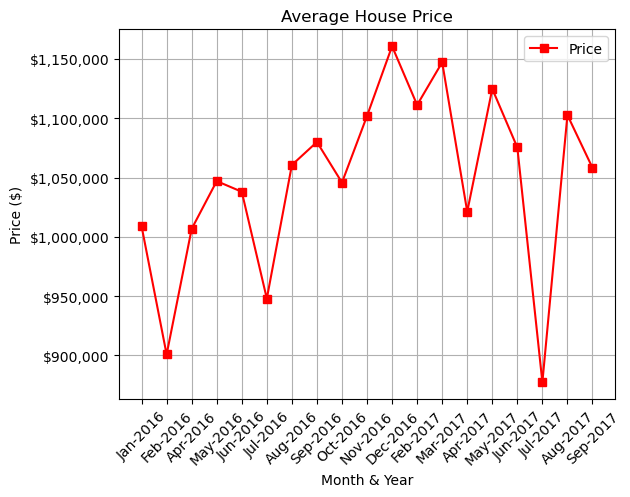

<Figure size 640x480 with 0 Axes>

In [95]:
# Get the unique values in the "Month_Year" column
x_labels = price_by_month_year["Month_Year"].unique()

# Plot a line plot of the dataframe
ax = price_by_month_year.plot(kind="line", x="Month_Year", y="Price", marker="s", color="r")

# Set the x-axis labels to be the unique values in the "Month_Year" column
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45)

# Format the y-axis ticks to display values in dollars
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

plt.ylabel("Price ($)")
plt.xlabel("Month & Year")
plt.title("Average House Price")

# Display the plot
plt.grid()
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/AverageHousePricevsPeriod")


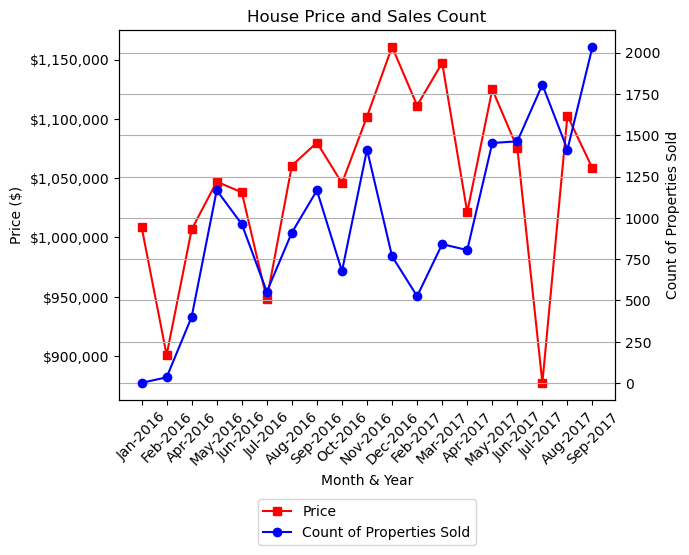

<Figure size 640x480 with 0 Axes>

In [97]:
# Create a figure and axis objects
fig, ax1 = plt.subplots()

# Add a second axis
ax2 = ax1.twinx()

# Set x-axis label
ax1.set_xlabel("Month & Year")

# Set the x-axis labels to be the unique values in the "Month_Year" column
ax1.set_xticks(range(len(x_labels)))
ax1.set_xticklabels(x_labels, rotation=45)

# Set y-axis labels
ax1.set_ylabel("Price ($)")
ax2.set_ylabel("Count of Properties Sold")

# Format the y-axis ticks to display values in dollars
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)

# Plot the data on each axis and add legends
p1 = ax1.plot(price_by_month_year["Month_Year"], price_by_month_year["Price"], color="red",marker="s", label="Price")
p2 = ax2.plot(price_by_month_year["Month_Year"], price_by_month_year["Count of Sales"], color="b",marker="o", label="Count of Properties Sold")

# Combine the legends and place it below the graph title
lines = p1 + p2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25))

# Set the title
plt.title("House Price and Sales Count")

# Show the plot
plt.grid()
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/AverageHousePricevsPeriod(IncludingCountofSales)")

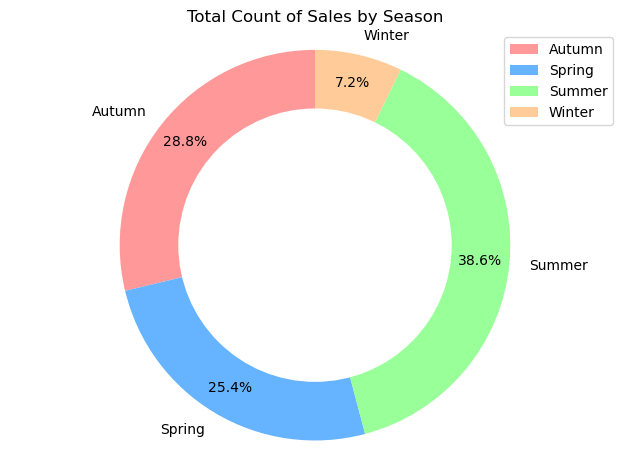

<Figure size 640x480 with 0 Axes>

In [99]:
# Group the data by season and sum the sales for each group
sales_by_season = price_by_month_year.groupby('Season')['Count of Sales'].sum()

# Create a donut chart of the sales by season
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(sales_by_season, labels=sales_by_season.index, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, labeldistance=1.1, wedgeprops={'width': 0.5})
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title and legend to the chart
plt.title('Total Count of Sales by Season')
plt.legend(labels=sales_by_season.index, loc='upper right')

# Display the chart
plt.axis('equal')
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/SalesbySeasons")


In [100]:
#Correct column headings 
interest_rate_df = interest_rate_database.rename(columns={'Date*': 'Date',"Owner Occupier Standard Variable Rate":"Avg_Standard_Rate"})

# Convert 'Date' column to pandas datetime object
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%b-%y')

# Extract Month_Year as separate column
interest_rate_df['Month_Year'] = interest_rate_df['Date'].dt.strftime('%b-%Y')

#Rearrange the columns
interest_rate_df = interest_rate_df[["Month_Year","Avg_Standard_Rate","RBA Cash Rate"]]

# Display resulting dataframe
interest_rate_df.head()

,Month_Year,Avg_Standard_Rate,RBA Cash Rate
0,Mar-2023,NaN,3.60
1,Feb-2023,7.77,3.35
2,Dec-2022,7.52,3.10
3,Nov-2022,7.27,2.85
4,Oct-2022,7.02,2.60


In [101]:
#Merge interest_rate_df to the price_by_month_year for regression analysis
price_interest_rate_df = price_by_month_year.merge(interest_rate_df, on='Month_Year')
price_interest_rate_df.head()

,Month_Year,Price,Count of Sales,Season,Avg_Standard_Rate,RBA Cash Rate
0,Jan-2016,1.009000e+06,2,Winter,5.46,2.00
1,Feb-2016,9.008214e+05,35,Winter,5.46,2.00
2,Apr-2016,1.006784e+06,401,Spring,5.46,2.00
3,May-2016,1.047057e+06,1167,Spring,5.39,1.75
4,Jun-2016,1.038088e+06,962,Summer,5.39,1.75


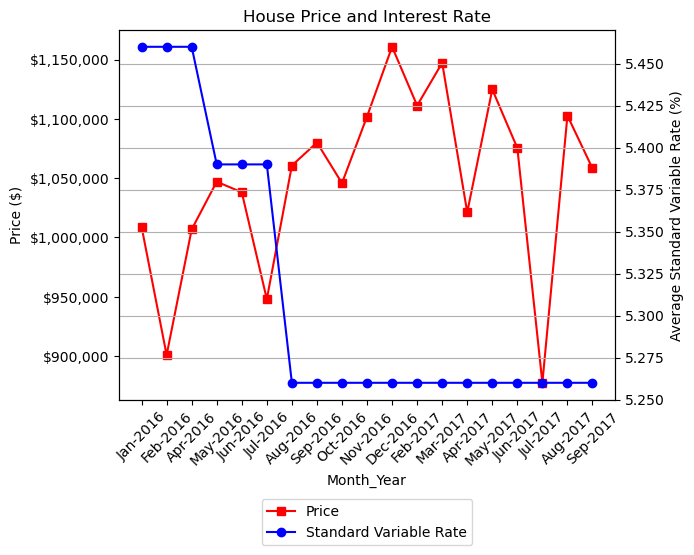

<Figure size 640x480 with 0 Axes>

In [103]:
# Create a figure and axis objects
fig, ax1 = plt.subplots()

# Add a second axis
ax2 = ax1.twinx()

# Set x-axis label
ax1.set_xlabel("Month_Year")

# Set the x-axis labels to be the unique values in the "Month_Year" column
ax1.set_xticks(range(len(x_labels)))
ax1.set_xticklabels(x_labels, rotation=45)

# Set y-axis labels
ax1.set_ylabel("Price ($)")
ax2.set_ylabel("Average Standard Variable Rate (%)")

# Format the y-axis ticks to display values in dollars
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)

# Plot the data on each axis and add legends
p1 = ax1.plot(price_interest_rate_df["Month_Year"], price_interest_rate_df["Price"], color="red",marker="s", label="Price")
p2 = ax2.plot(price_interest_rate_df["Month_Year"], price_interest_rate_df["Avg_Standard_Rate"], color="blue",marker="o", label="Standard Variable Rate")

# Combine the legends and place it below the graph title
lines = p1 + p2
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.25))

# Set the title
plt.title("House Price and Interest Rate")

# Show the plot
plt.grid()
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/PriceVsPeriod&InterestRate")



5KM Radius Data Range from CBD (All Property Types)#

In [106]:
# Start Work for API Call Section
api_call_df = property_database[["Suburb", "Address", "Price", "Lattitude", "Longtitude", "Type", "Distance","CouncilArea"]]

# Set distance as int64 value and then filter for less than 5kms
api_call_df["Distance"] = api_call_df["Distance"].astype("float")
api_call_df = api_call_df.loc[api_call_df["Distance"] <= 5]

# Drop any NA values in the dataframe
api_call_df = api_call_df.dropna()

# Show dataframe
api_call_df

/var/folders/c6/f4lv068572x0t6lvnvn2yjyc0000gn/T/ipykernel_60527/3716360422.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Suburb,Address,Price,Lattitude,Longtitude,Type,Distance,CouncilArea
0,Abbotsford,85 Turner St,1480000,-37.79960,144.99840,h,2.5,Yarra
1,Abbotsford,25 Bloomburg St,1035000,-37.80790,144.99340,h,2.5,Yarra
2,Abbotsford,5 Charles St,1465000,-37.80930,144.99440,h,2.5,Yarra
3,Abbotsford,40 Federation La,850000,-37.79690,144.99690,h,2.5,Yarra
4,Abbotsford,55a Park St,1600000,-37.80720,144.99410,h,2.5,Yarra
...,...,...,...,...,...,...,...,...
15346,South Yarra,10/38 Kensington Rd,555000,-37.83631,145.00181,u,2.7,Stonnington
15347,Southbank,101/8 Wells St,732000,-37.82618,144.96891,u,0.7,Melbourne
15349,St Kilda,11/22 Charnwood Cr,481000,-37.85984,144.98670,u,5.0,Port Phillip
15350,St Kilda,45/151 Fitzroy St,600000,-37.85911,144.97900,u,5.0,Port Phillip


In [ ]:
# Set parameters to search for nearby locations
radius = 2000
categories = ["public_transport.train"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_df.iterrows():

        # # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_df[f"{category} Name"] = [results[category][index] for index in api_call_df.index]

# Display the updated DataFrame
print(api_call_df)

# Export the City_Data into a csv
api_call_df.to_csv("Output Data/api_call_transport.csv")


In [ ]:
# Read saved data
api_call_df = pd.read_csv("Output Data/api_call_transport.csv")

# Set parameters to search for nearby locations
radius = 2000
categories = ["commercial.shopping_mall"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_df.iterrows():

        # # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_df[f"{category} Name"] = [results[category][index] for index in api_call_df.index]

# Display the updated DataFrame
print(api_call_df)

# Export the City_Data into a csv
api_call_df.to_csv("Output Data/api_call_shopping.csv")

In [ ]:
# Read saved data
api_call_df = pd.read_csv("Output Data/api_call_shopping.csv")

# Set parameters to search for nearby locations
radius = 2000
categories = ["healthcare"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_df.iterrows():

        # # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_df[f"{category} Name"] = [results[category][index] for index in api_call_df.index]

# Display the updated DataFrame
print(api_call_df)

# Export the City_Data into a csv
api_call_df.to_csv("Output Data/api_call_healthcare.csv")

In [ ]:
# Read saved data
api_call_df = pd.read_csv("Output Data/api_call_healthcare.csv")
# Drop unwanted columns
api_call_df = api_call_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"])

# Show the first few rows of the DataFrame
api_call_df.head()

# Set parameters to search for nearby locations
radius = 2000
categories = ["tourism.attraction"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_df.iterrows():

        # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_df[f"{category} Name"] = [results[category][index] for index in api_call_df.index]

# Display the updated DataFrame
print(api_call_df)

# Export the City_Data into a csv
api_call_df.to_csv("Output Data/api_call_tourism_attraction.csv")

In [ ]:
# Read saved data
api_call_df = pd.read_csv("Output Data/api_call_tourism_attraction.csv")

# Drop unwanted columns
api_call_df = api_call_df.drop(columns=["Unnamed: 0"])
api_call_df.head()

# Show the first few rows of the DataFrame
api_call_df.head()

# Set parameters to search for nearby locations
radius = 2000
categories = ["leisure.park.nature_reserve"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_df.iterrows():

        # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_df[f"{category} Name"] = [results[category][index] for index in api_call_df.index]

# Display the updated DataFrame
print(api_call_df)

# Export the City_Data into a csv
api_call_df.to_csv("Output Data/api_call_park.csv")


In [4]:
# Read saved data
unique_indicators_df = pd.read_csv("Output Data/api_call_park.csv")

# Drop unwanted columns
unique_indicators_df = unique_indicators_df.drop(columns=["Unnamed: 0"])
unique_indicators_df.head()

# replace 'Yes' with 1
unique_indicators_df['public_transport.train Name'] = unique_indicators_df['public_transport.train Name'].replace({'Yes': 1})
unique_indicators_df['public_transport.train Name'] = unique_indicators_df['public_transport.train Name'].replace({"Not found": 0})

unique_indicators_df['commercial.shopping_mall Name'] = unique_indicators_df['commercial.shopping_mall Name'].replace({'Yes': 1})
unique_indicators_df['commercial.shopping_mall Name'] = unique_indicators_df['commercial.shopping_mall Name'].replace({"Not found": 0})

unique_indicators_df['healthcare Name'] = unique_indicators_df['healthcare Name'].replace({'Yes': 1})
unique_indicators_df['healthcare Name'] = unique_indicators_df['healthcare Name'].replace({"Not found": 0})

unique_indicators_df['tourism.attraction Name'] = unique_indicators_df['tourism.attraction Name'].replace({'Yes': 1})
unique_indicators_df['tourism.attraction Name'] = unique_indicators_df['tourism.attraction Name'].replace({"Not found": 0})

unique_indicators_df['leisure.park.nature_reserve Name'] = unique_indicators_df['leisure.park.nature_reserve Name'].replace({'Yes': 1})
unique_indicators_df['leisure.park.nature_reserve Name'] = unique_indicators_df['leisure.park.nature_reserve Name'].replace({"Not found": 0})

#Rename Columns
unique_indicators_df = unique_indicators_df.rename(columns={"public_transport.train Name": "Public Transport", "commercial.shopping_mall Name" : "Shopping Mall", "healthcare Name":"Healthcare", "tourism.attraction Name" : "Tourism Attraction", "leisure.park.nature_reserve Name" :"Park"})

#Calculate the Number of Stars
unique_indicators_df["Star Rating"] = unique_indicators_df[["Public Transport", "Shopping Mall", "Healthcare", "Tourism Attraction", "Park"]].sum(axis=1)
unique_indicators_df.head()

,Suburb,Address,Price,Lattitude,Longtitude,Type,Distance,CouncilArea,Public Transport,Shopping Mall,Healthcare,Tourism Attraction,Park,Star Rating
0,Abbotsford,85 Turner St,1480000,-37.7996,144.9984,h,2.5,Yarra,1,1,1,1,1,5
1,Abbotsford,25 Bloomburg St,1035000,-37.8079,144.9934,h,2.5,Yarra,1,1,1,1,1,5
2,Abbotsford,5 Charles St,1465000,-37.8093,144.9944,h,2.5,Yarra,1,1,1,1,1,5
3,Abbotsford,40 Federation La,850000,-37.7969,144.9969,h,2.5,Yarra,1,1,1,1,1,5
4,Abbotsford,55a Park St,1600000,-37.8072,144.9941,h,2.5,Yarra,1,1,1,1,1,5


In [5]:
#Groupby each factor Public Transport", "Shopping Mall", "Healthcare", "Tourism Attraction", "Park"
mean_price_by_publictransport = unique_indicators_df.groupby("Public Transport")["Price"].mean()
print(mean_price_by_publictransport)

mean_price_by_shoppingmall = unique_indicators_df.groupby("Shopping Mall")["Price"].mean()
print(mean_price_by_shoppingmall)

mean_price_by_healthcare = unique_indicators_df.groupby("Healthcare")["Price"].mean()
print(mean_price_by_healthcare)

mean_price_by_attraction = unique_indicators_df.groupby("Tourism Attraction")["Price"].mean()
print(mean_price_by_attraction)

mean_price_by_park = unique_indicators_df.groupby("Park")["Price"].mean()
print(mean_price_by_park)

# Create a DataFrame with the mean prices for each factor
star_rating_df = pd.DataFrame({
    "Public Transport": mean_price_by_publictransport,
    "Shopping Mall": mean_price_by_shoppingmall,
    "Healthcare": mean_price_by_healthcare,
    "Tourism Attraction": mean_price_by_attraction,
    "Park": mean_price_by_park
})

# Print the DataFrame
star_rating_df

Public Transport
0    1.511648e+06
1    1.067890e+06
Name: Price, dtype: float64
Shopping Mall
0    1.455597e+06
1    1.099026e+06
Name: Price, dtype: float64
Healthcare
1    1.115563e+06
Name: Price, dtype: float64
Tourism Attraction
0    3.295000e+06
1    1.111430e+06
Name: Price, dtype: float64
Park
0    1.156550e+06
1    1.089257e+06
Name: Price, dtype: float64


,Public Transport,Shopping Mall,Healthcare,Tourism Attraction,Park
0,1.511648e+06,1.455597e+06,NaN,3.295000e+06,1.156550e+06
1,1.067890e+06,1.099026e+06,1.115563e+06,1.111430e+06,1.089257e+06


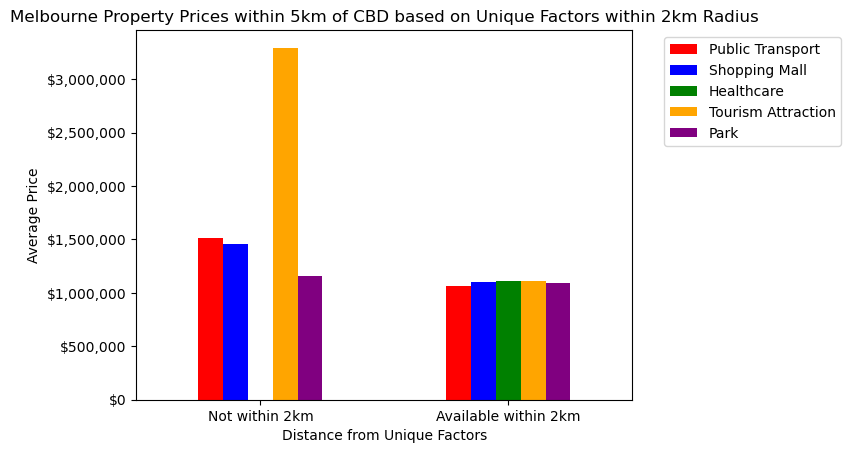

<Figure size 640x480 with 0 Axes>

In [6]:
star_rating_df.index = ["Not within 2km", "Available within 2km"]
star_rating_df = star_rating_df.astype("float")

#Create a Colour lIST
colors = ['red', 'blue', 'green', 'orange', 'purple']
#Plot the bar chart of the two different section
ax = star_rating_df.plot(kind="bar", color = colors)
ax.set_xlabel("Distance from Unique Factors")
ax.set_ylabel("Average Price")
ax.set_title("Melbourne Property Prices within 5km of CBD based on Unique Factors within 2km Radius")

# Format the y-axis ticks to display values in dollars
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# Set the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/AvgPricePerUniqueFactorWithin2kmRadius-5KM_Data")

In [17]:
# Define the bins for the Star Rating
bins = [0, 1, 2, 3, 4, 5]

# Create a new column with the binned values
unique_indicators_df["Star Rating Bins"] = pd.cut(unique_indicators_df["Star Rating"], bins=bins, labels=["1 star", "2 stars", "3 stars", "4 stars", "5 stars"])

# Calculate the mean price for each star rating
mean_price_by_rating = unique_indicators_df.groupby("Star Rating Bins")["Price"].mean()
mean_price_by_rating.head()

# Create a data frame from the mean_price_by_rating2 series
mean_price_by_rating_df = pd.DataFrame(mean_price_by_rating)

# Reset the index
mean_price_by_rating_df = mean_price_by_rating_df.reset_index()

# Rename the columns
mean_price_by_rating_df = mean_price_by_rating_df.rename(columns={"Price": "Mean Price", "Star Rating Bins": "Star Rating"})

# Create a polar chart with the mean price by star rating
fig = go.Figure(data=go.Scatterpolar(
      r=mean_price_by_rating_df['Mean Price'],
      theta=mean_price_by_rating_df['Star Rating'],
      fill='toself',
      hovertemplate='Average Price: $%{r:,.0f}<br>Star Count: %{theta}',
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      tickprefix='$',
      tickformat=",",
    ),
  ),
  showlegend=False,
  title='Average Price by Star Rating',
)

fig.show()

fig.write_image("Output Data/Graph Images/MeanPricebyStarRating-5KM_Data.png")


               Average Star Rating  Count of Properties
CouncilArea                                            
Boroondara                4.083333                  132
Maribyrnong               4.470588                   17
Melbourne                 4.408511                  470
Moonee Valley             4.988636                   88
Moreland                  4.313253                   83


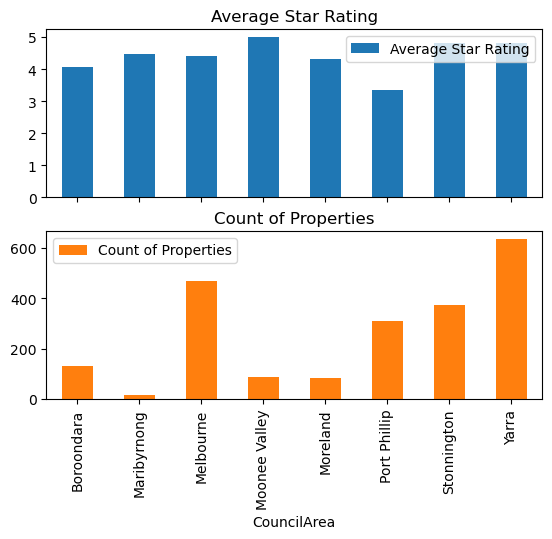

<Figure size 640x480 with 0 Axes>

In [18]:
#Get the council vs star rating mean
council_star = unique_indicators_df.groupby("CouncilArea")["Star Rating"].mean()
#Get the council vs address count
council_address = unique_indicators_df.groupby("CouncilArea")["Address"].count()

#create a dataframe
council_data = pd.concat([council_star, council_address], axis=1)
council_data.columns = ["Average Star Rating", "Count of Properties"]
print(council_data.head())

#plot histogram of suburb and the two metrics 
council_data.plot(kind="bar", rot=90, subplots=True)
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/CouncilArea&AvgStarRating&CountOfProperties-5KM_Data")

In [ ]:
#Increased Data Range with greater radius for comparision (Only Houses)#

In [10]:
# Start Work for API Call Section
api_call_add_range_df = property_database[["Suburb", "Address", "Price", "Lattitude", "Longtitude", "Type", "Distance","CouncilArea"]]

# Set distance as int64 value and then filter for less than 20kms bu greater than 10km
api_call_add_range_df["Distance"] = api_call_add_range_df["Distance"].astype("float")
api_call_add_range_df = api_call_add_range_df.loc[(api_call_add_range_df["Distance"] > 10) & (api_call_add_range_df["Distance"] < 20)]

# Set type as h value
api_call_add_range_df = api_call_add_range_df.loc[(api_call_add_range_df["Type"] == "h")]

# Drop any NA values in the dataframe
api_call_add_range_df = api_call_add_range_df.dropna()

# Show dataframe
api_call_add_range_df


/var/folders/c6/f4lv068572x0t6lvnvn2yjyc0000gn/T/ipykernel_81928/1541004189.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Suburb,Address,Price,Lattitude,Longtitude,Type,Distance,CouncilArea
53,Airport West,50 Bedford St,730000,-37.72030,144.87550,h,13.5,Moonee Valley
54,Airport West,50 Bedford St,770000,-37.72030,144.87550,h,13.5,Moonee Valley
55,Airport West,23 Hart St,603000,-37.72940,144.88800,h,13.5,Moonee Valley
57,Airport West,1/37 Hillside Gr,600000,-37.72730,144.87440,h,13.5,Moonee Valley
64,Airport West,54 Marshall Rd,720000,-37.71730,144.88720,h,13.5,Moonee Valley
...,...,...,...,...,...,...,...,...
15381,Werribee,46 Coventry Dr,482500,-37.89337,144.64003,h,14.7,Wyndham
15383,Werribee,40 Tarneit Rd,597000,-37.89402,144.66276,h,14.7,Wyndham
15385,Westmeadows,43 Bamford Av,821000,-37.67841,144.87924,h,16.5,Hume
15386,Westmeadows,4 Pershore Ct,635000,-37.68026,144.88468,h,16.5,Hume


In [ ]:
# Set parameters to search for nearby locations
radius = 2000
categories = ["public_transport.train"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_add_range_df.iterrows():

        # # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_add_range_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_add_range_df[f"{category} Name"] = [results[category][index] for index in api_call_add_range_df.index]

# Display the updated DataFrame
print(api_call_add_range_df)

# Export the City_Data into a csv
api_call_add_range_df.to_csv("Output Data/api_call_transport_new.csv")

In [ ]:
# Read saved data
api_call_add_range_df = pd.read_csv("Output Data/api_call_transport_new.csv")

# Set parameters to search for nearby locations
radius = 2000
categories = ["commercial.shopping_mall"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_add_range_df.iterrows():

        # # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_add_range_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_add_range_df[f"{category} Name"] = [results[category][index] for index in api_call_add_range_df.index]

# Display the updated DataFrame
print(api_call_add_range_df)

# Export the City_Data into a csv
api_call_add_range_df.to_csv("Output Data/api_call_shopping_new.csv")

In [ ]:
# Read saved data
api_call_add_range_df = pd.read_csv("Output Data/api_call_shopping_new.csv")

# Set parameters to search for nearby locations
radius = 2000
categories = ["healthcare"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_add_range_df.iterrows():

        # # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_add_range_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_add_range_df[f"{category} Name"] = [results[category][index] for index in api_call_add_range_df.index]

# Display the updated DataFrame
print(api_call_add_range_df)

# Export the City_Data into a csv
api_call_add_range_df.to_csv("Output Data/api_call_healthcare_new.csv")

In [ ]:
# Read saved data
api_call_add_range_df = pd.read_csv("Output Data/api_call_healthcare_new.csv")
# Drop unwanted columns
api_call_add_range_df = api_call_add_range_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"])

# Show the first few rows of the DataFrame
api_call_add_range_df.head()

# Set parameters to search for nearby locations
radius = 2000
categories = ["tourism.attraction"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_add_range_df.iterrows():

        # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_add_range_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_add_range_df[f"{category} Name"] = [results[category][index] for index in api_call_add_range_df.index]

# Display the updated DataFrame
print(api_call_add_range_df)

# Export the City_Data into a csv
api_call_add_range_df.to_csv("Output Data/api_call_tourism_attraction_new.csv")

In [5]:
# Read saved data
api_call_add_range_df = pd.read_csv("Output Data/api_call_tourism_attraction_new.csv")

# Drop unwanted columns
api_call_add_range_df = api_call_add_range_df.drop(columns=["Unnamed: 0"])
api_call_add_range_df.head()

# Show the first few rows of the DataFrame
api_call_add_range_df.head()

# Set parameters to search for nearby locations
radius = 2000
categories = ["leisure.park.nature_reserve"]

# Create a dictionary to store the results
results = {}

# Iterate through each category
for category in categories:
    params = {
        "categories": category,
        "apiKey": geoapify_key,
        "limit": 20
    }

    # Print a message to follow up the location search
    print(f"Starting {category} search")

    # Create counters
    record_count = 1
    set_count = 1
 
    # Iterate through the api_call_df DataFrame
    for index, row in api_call_add_range_df.iterrows():

        # Get the address's name
        address = row["Address"]
        
        # Get latitude, longitude from the DataFrame
        latitude = row["Lattitude"]
        longitude = row["Longtitude"]
        
        # Add filter and bias parameters with the current address's latitude and longitude to the params dictionary
        params["filter"] = f"circle:{longitude},{latitude},{radius}"
        params["bias"] = f"proximity:{longitude},{latitude}"
        
        # Set base URL
        base_url = "https://api.geoapify.com/v2/places?"
       
        # Make and API request using the params dictionary
        name_address = requests.get(base_url, params=params)
        
        # Convert the API response to JSON format
        name_address = name_address.json()
    
        # Check if a location is found and store the result in the results dictionary
        if name_address["features"]:
            results.setdefault(category, {})[index] = "Yes"
        else:
            results.setdefault(category, {})[index] = "Not found"
            
        # Log the search results
        print(f"{api_call_add_range_df.loc[index, 'Address']} - nearest {category}: {results[category][index]}")

    # Append the results for this category to a new column in the api_call_df DataFrame
    api_call_add_range_df[f"{category} Name"] = [results[category][index] for index in api_call_add_range_df.index]

# Display the updated DataFrame
print(api_call_add_range_df)

# Export the City_Data into a csv
api_call_add_range_df.to_csv("Output Data/api_call_park_new.csv")

Starting leisure.park.nature_reserve search
50 Bedford St - nearest leisure.park.nature_reserve: Yes
50 Bedford St - nearest leisure.park.nature_reserve: Yes
23 Hart St - nearest leisure.park.nature_reserve: Yes
1/37 Hillside Gr - nearest leisure.park.nature_reserve: Yes
54 Marshall Rd - nearest leisure.park.nature_reserve: Yes
36 Roberts Rd - nearest leisure.park.nature_reserve: Yes
11 Harrington Rd - nearest leisure.park.nature_reserve: Yes
3 Deidre Ct - nearest leisure.park.nature_reserve: Yes
13 Etzel St - nearest leisure.park.nature_reserve: Yes
241 Parer Rd - nearest leisure.park.nature_reserve: Yes
180 Parer Rd - nearest leisure.park.nature_reserve: Yes
43 Hillside Gr - nearest leisure.park.nature_reserve: Yes
174 Parer Rd - nearest leisure.park.nature_reserve: Yes
138 Victory Rd - nearest leisure.park.nature_reserve: Yes
75 King St - nearest leisure.park.nature_reserve: Yes
6 Kittyhawk St - nearest leisure.park.nature_reserve: Yes
478 Fullarton Rd - nearest leisure.park.nature_

In [11]:
# Read saved data
unique_indicators_add_range_df = pd.read_csv("Output Data/api_call_park_new.csv")

# Drop unwanted columns
unique_indicators_add_range_df = unique_indicators_add_range_df.drop(columns=["Unnamed: 0"])
unique_indicators_add_range_df.head()

# replace 'Yes' with 1
unique_indicators_add_range_df['public_transport.train Name'] = unique_indicators_add_range_df['public_transport.train Name'].replace({'Yes': 1})
unique_indicators_add_range_df['public_transport.train Name'] = unique_indicators_add_range_df['public_transport.train Name'].replace({"Not found": 0})

unique_indicators_add_range_df['commercial.shopping_mall Name'] = unique_indicators_add_range_df['commercial.shopping_mall Name'].replace({'Yes': 1})
unique_indicators_add_range_df['commercial.shopping_mall Name'] = unique_indicators_add_range_df['commercial.shopping_mall Name'].replace({"Not found": 0})

unique_indicators_add_range_df['healthcare Name'] = unique_indicators_add_range_df['healthcare Name'].replace({'Yes': 1})
unique_indicators_add_range_df['healthcare Name'] = unique_indicators_add_range_df['healthcare Name'].replace({"Not found": 0})

unique_indicators_add_range_df['tourism.attraction Name'] = unique_indicators_add_range_df['tourism.attraction Name'].replace({'Yes': 1})
unique_indicators_add_range_df['tourism.attraction Name'] = unique_indicators_add_range_df['tourism.attraction Name'].replace({"Not found": 0})

unique_indicators_add_range_df['leisure.park.nature_reserve Name'] = unique_indicators_add_range_df['leisure.park.nature_reserve Name'].replace({'Yes': 1})
unique_indicators_add_range_df['leisure.park.nature_reserve Name'] = unique_indicators_add_range_df['leisure.park.nature_reserve Name'].replace({"Not found": 0})

#Rename Columns
unique_indicators_add_range_df = unique_indicators_add_range_df.rename(columns={"public_transport.train Name": "Public Transport", "commercial.shopping_mall Name" : "Shopping Mall", "healthcare Name":"Healthcare", "tourism.attraction Name" : "Tourism Attraction", "leisure.park.nature_reserve Name" :"Park"})

#Calculate the Number of Stars
unique_indicators_add_range_df["Star Rating"] = unique_indicators_add_range_df[["Public Transport", "Shopping Mall", "Healthcare", "Tourism Attraction", "Park"]].sum(axis=1)
unique_indicators_add_range_df.head()

,Suburb,Address,Price,Lattitude,Longtitude,Type,Distance,CouncilArea,Public Transport,Shopping Mall,Healthcare,Tourism Attraction,Park,Star Rating
0,Airport West,50 Bedford St,730000,-37.7203,144.8755,h,13.5,Moonee Valley,0,1,1,1,1,4
1,Airport West,50 Bedford St,770000,-37.7203,144.8755,h,13.5,Moonee Valley,0,1,1,1,1,4
2,Airport West,23 Hart St,603000,-37.7294,144.8880,h,13.5,Moonee Valley,0,1,1,1,1,4
3,Airport West,1/37 Hillside Gr,600000,-37.7273,144.8744,h,13.5,Moonee Valley,0,1,1,1,1,4
4,Airport West,54 Marshall Rd,720000,-37.7173,144.8872,h,13.5,Moonee Valley,0,1,1,0,1,3


In [12]:
# Groupby each factor Public Transport", "Shopping Mall", "Healthcare", "Tourism Attraction", "Park"
mean_price_by_publictransport2 = unique_indicators_add_range_df.groupby("Public Transport")["Price"].mean()
print(mean_price_by_publictransport2)

mean_price_by_shoppingmall2 = unique_indicators_add_range_df.groupby("Shopping Mall")["Price"].mean()
print(mean_price_by_shoppingmall2)

mean_price_by_healthcare2 = unique_indicators_add_range_df.groupby("Healthcare")["Price"].mean()
print(mean_price_by_healthcare2)

mean_price_by_attraction2 = unique_indicators_add_range_df.groupby("Tourism Attraction")["Price"].mean()
print(mean_price_by_attraction2)

mean_price_by_park2 = unique_indicators_add_range_df.groupby("Park")["Price"].mean()
print(mean_price_by_park2)

# Create a DataFrame with the mean prices for each factor
star_rating_df2 = pd.DataFrame({
    "Public Transport": mean_price_by_publictransport2,
    "Shopping Mall": mean_price_by_shoppingmall2,
    "Healthcare": mean_price_by_healthcare2,
    "Tourism Attraction": mean_price_by_attraction2,
    "Park": mean_price_by_park2
})

# Print the DataFrame
star_rating_df2

# # Remove Healthcare column from the DataFrame
# star_rating_df = star_rating_df[["Public Transport","Shopping Mall","Tourism Attraction","Park"]]
# star_rating_df

Public Transport
0    1.003434e+06
1    1.143582e+06
Name: Price, dtype: float64
Shopping Mall
0    1.203274e+06
1    1.071384e+06
Name: Price, dtype: float64
Healthcare
0    6.690603e+05
1    1.112341e+06
Name: Price, dtype: float64
Tourism Attraction
0    1.011395e+06
1    1.139717e+06
Name: Price, dtype: float64
Park
0    1.200186e+06
1    9.689882e+05
Name: Price, dtype: float64


,Public Transport,Shopping Mall,Healthcare,Tourism Attraction,Park
0,1.003434e+06,1.203274e+06,6.690603e+05,1.011395e+06,1.200186e+06
1,1.143582e+06,1.071384e+06,1.112341e+06,1.139717e+06,9.689882e+05


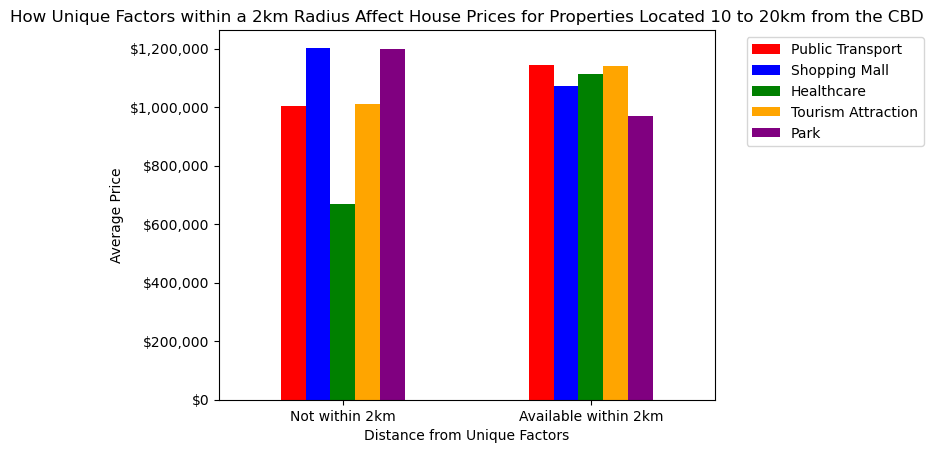

<Figure size 640x480 with 0 Axes>

In [14]:
star_rating_df2.index = ["Not within 2km", "Available within 2km"]
star_rating_df = star_rating_df2.astype("float")

#Create a Colour lIST
colors = ['red', 'blue', 'green', 'orange', 'purple']
#Plot the bar chart of the two different section
ax = star_rating_df.plot(kind="bar", color = colors)
ax.set_xlabel("Distance from Unique Factors")
ax.set_ylabel("Average Price")
ax.set_title("How Unique Factors within a 2km Radius Affect House Prices for Properties Located 10 to 20km from the CBD")

# Format the y-axis ticks to display values in dollars
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

# Set the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/AvgPricePerUniqueFactorWithin2kmRadius-10KM_to_20km_Data")


In [15]:
# Define the bins for the Star Rating
bins = [0, 1, 2, 3, 4, 5]

# Create a new column with the binned values
unique_indicators_add_range_df["Star Rating Bins"] = pd.cut(unique_indicators_add_range_df["Star Rating"], bins=bins, labels=["1 star", "2 stars", "3 stars", "4 stars", "5 stars"])

# Calculate the mean price for each star rating
mean_price_by_rating2 = unique_indicators_add_range_df.groupby("Star Rating Bins")["Price"].mean()

# Create a data frame from the mean_price_by_rating2 series
mean_price_by_rating_df2 = pd.DataFrame(mean_price_by_rating2)

# Reset the index
mean_price_by_rating_df2 = mean_price_by_rating_df2.reset_index()

# Rename the columns
mean_price_by_rating_df2 = mean_price_by_rating_df2.rename(columns={"Price": "Mean Price", "Star Rating Bins": "Star Rating"})

# Create a polar chart with the mean price by star rating
fig = go.Figure(data=go.Scatterpolar(
      r=mean_price_by_rating_df2['Mean Price'],
      theta=mean_price_by_rating_df2['Star Rating'],
      fill='toself',
      hovertemplate='Average Price: $%{r:,.0f}<br>Star Count: %{theta}',
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      tickprefix='$',
      tickformat=",",
    ),
  ),
  showlegend=False,
  title='Average Price by Star Rating',
)

fig.show()

fig.write_image("Output Data/Graph Images/MeanPricebyStarRating_10_to_20km_Dataset.png")

             Average Star Rating  Count of Properties
CouncilArea                                          
Banyule                 4.413043                  276
Bayside                 3.347267                  311
Boroondara              3.888889                   90
Brimbank                3.739474                  380
Darebin                 3.532468                  231


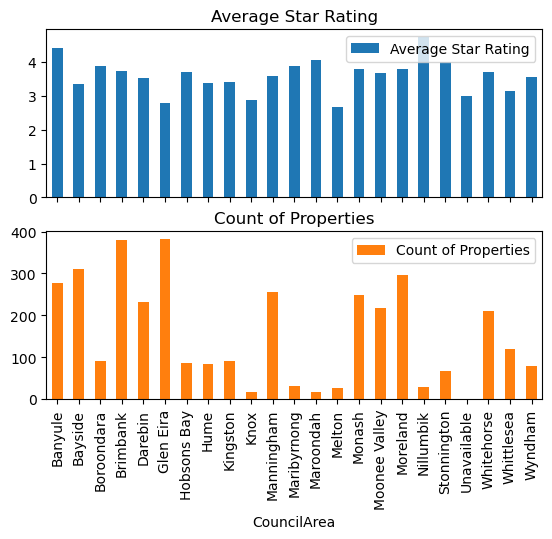

<Figure size 640x480 with 0 Axes>

In [16]:
#Get the council vs star rating mean
council_star = unique_indicators_add_range_df.groupby("CouncilArea")["Star Rating"].mean()
#Get the council vs address count
council_address = unique_indicators_add_range_df.groupby("CouncilArea")["Address"].count()

#create a dataframe
council_data = pd.concat([council_star, council_address], axis=1)
council_data.columns = ["Average Star Rating", "Count of Properties"]
print(council_data.head())

#plot histogram of suburb and the two metrics 
council_data.plot(kind="bar", rot=90, subplots=True)
plt.show()

# Save the figure
plt.savefig("Output Data/Graph Images/CouncilArea&AvgStarRating&CountOfProperties-10KM_to_20km_Data")

